In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import collections
import matplotlib.pyplot as plt

In [7]:
def load_data(folder):
    data = []
    labels = []
    for label, subfolder in enumerate(['control', 'condition']):
        path = os.path.join(folder, subfolder)
        for file in os.listdir(path):
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(path, file))
                data.append(df[['timestamp', 'activity']].values)
                labels.append(label)
    return data, labels

data, labels = load_data('data')

In [8]:
# Checking class imbalance before augmentation
class_distribution_before = collections.Counter(labels)
print("Class distribution before augmentation:", class_distribution_before)

Class distribution before augmentation: Counter({0: 32, 1: 23})


In [9]:
def preprocess_data(data):
    processed_data = []
    for sequence in data:
        df = pd.DataFrame(sequence, columns=['timestamp', 'activity'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['hour'] = df['timestamp'].dt.hour
        processed_data.append(df[['hour', 'activity']].values)
    return processed_data

processed_data = preprocess_data(data)

scaler = StandardScaler()
for i in range(len(processed_data)):
    processed_data[i] = scaler.fit_transform(processed_data[i])

def add_noise(data, noise_factor=0.1):
    noisy_data = []
    for sequence in data:
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=sequence.shape)
        noisy_sequence = sequence + noise
        noisy_data.append(noisy_sequence)
    return noisy_data

def scale_data(data, scaling_factor=1.1):
    scaled_data = []
    for sequence in data:
        scaling = np.random.uniform(low=1.0/scaling_factor, high=scaling_factor)
        scaled_sequence = sequence * scaling
        scaled_data.append(scaled_sequence)
    return scaled_data

In [10]:
# Apply noise and scaling to the processed data
noisy_data = add_noise(processed_data)
scaled_data = scale_data(processed_data)

# Combine original, noisy, and scaled data
augmented_data = processed_data + noisy_data + scaled_data
augmented_labels = labels * 3

In [11]:
# Checking class imbalance after augmentation
class_distribution_after = collections.Counter(augmented_labels)
print("Class distribution after augmentation:", class_distribution_after)

Class distribution after augmentation: Counter({0: 96, 1: 69})


In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in augmented_data)
X = pad_sequences(augmented_data, maxlen=max_len, dtype='float32', padding='post', truncating='post')
y = np.array(augmented_labels)

In [13]:
from imblearn.over_sampling import SMOTE

# Reshape X for SMote
n_samples, time_steps, n_features = X.shape
X_reshaped = X.reshape((n_samples, time_steps * n_features))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reshaped, y)

In [14]:
# Checking class imbalance after SMOTE
class_distribution_smote = collections.Counter(y_resampled)
print("Class distribution after SMOTE:", class_distribution_smote)

Class distribution after SMOTE: Counter({0: 96, 1: 96})


In [15]:
# Reshape X back to original form
X_resampled = X_resampled.reshape((X_resampled.shape[0], time_steps, n_features))

# Ensuring the features are correct
print("Sample augmented data:", augmented_data[0])

Sample augmented data: [[ 0.50425252 -0.13307351]
 [ 0.50425252 -0.34021828]
 [ 0.50425252  0.57121867]
 ...
 [ 0.07130386 -0.32986104]
 [ 0.07130386 -0.32986104]
 [ 0.07130386 -0.34021828]]


In [16]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
def create_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def plot_history(history, fold):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Fold {fold} Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Fold {fold} Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


c:\Users\vinse\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74s/step - accuracy: 0.5131 - loss: 2.3472  
Epoch 1: val_loss improved from inf to 0.54270, saving model to best_modelCekIni_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 311s 75s/step - accuracy: 0.5334 - loss: 2.3551 - val_accuracy: 0.8710 - val_loss: 0.5427
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83s/step - accuracy: 0.9423 - loss: 0.4129  
Epoch 2: val_loss improved from 0.54270 to 0.41932, saving model to best_modelCekIni_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 338s 85s/step - accuracy: 0.9358 - loss: 0.4429 - val_accuracy: 0.9032 - val_loss: 0.4193
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86s/step - accuracy: 0.9328 - loss: 0.5220  
Epoch 3: val_loss improved from 0.41932 to 0.00015, saving model to best_modelCekIni_fold_1.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 374s 88s/step - accuracy: 0.9331 - loss: 0.4910 - val_accuracy: 1.0000 - val_loss: 1.4525e-04
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89s/step - accuracy: 0.9953 - loss: 0.0767  
Epoch 4: val_loss did not

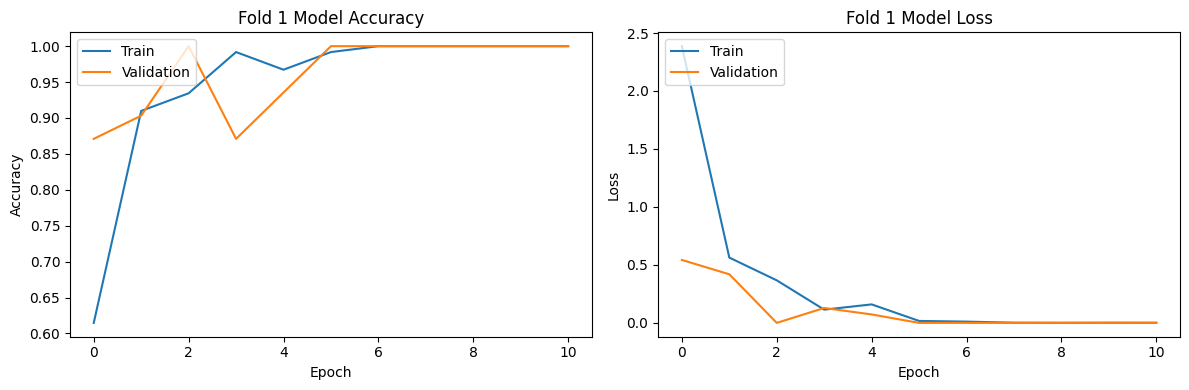

Fold 1 - Test Accuracy: 1.0000
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123s/step - accuracy: 0.6509 - loss: 4.2136  
Epoch 1: val_loss improved from inf to 0.00117, saving model to best_modelCekIni_fold_2.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 501s 126s/step - accuracy: 0.6519 - loss: 4.3071 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131s/step - accuracy: 0.7207 - loss: 2.0154  
Epoch 2: val_loss did not improve from 0.00117
4/4 ━━━━━━━━━━━━━━━━━━━━ 529s 135s/step - accuracy: 0.7323 - loss: 1.9110 - val_accuracy: 0.8065 - val_loss: 1.9427
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131s/step - accuracy: 0.8588 - loss: 0.7383  
Epoch 3: val_loss did not improve from 0.00117
4/4 ━━━━━━━━━━━━━━━━━━━━ 534s 134s/step - accuracy: 0.8657 - loss: 0.6998 - val_accuracy: 0.9032 - val_loss: 0.1090
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136s/step - accuracy: 0.9868 - loss: 0.0411    
Epoch 4: val_loss did not improve from 0.00117
4/4 ━━━━━━━━━━━━━━━━━━━━ 567s 139s/step - ac

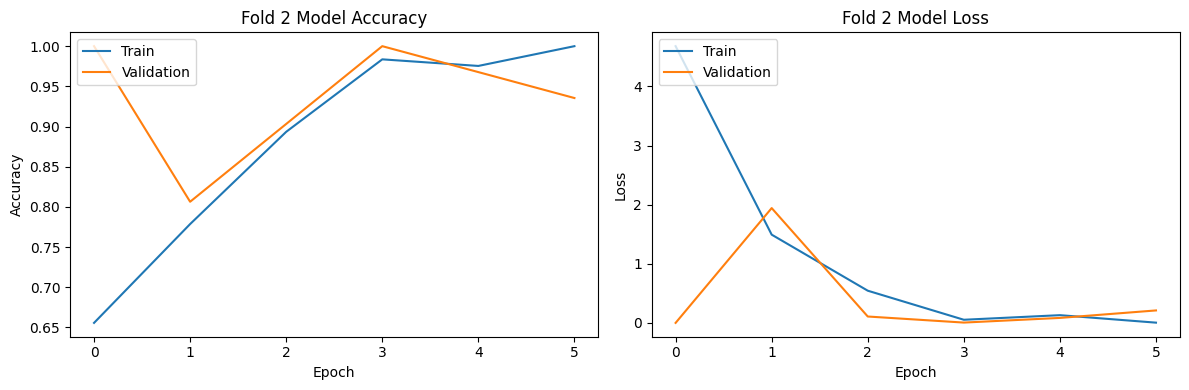

Fold 2 - Test Accuracy: 0.8718
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 156s/step - accuracy: 0.5581 - loss: 2.7867  
Epoch 1: val_loss improved from inf to 0.06756, saving model to best_modelCekIni_fold_3.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 638s 159s/step - accuracy: 0.5701 - loss: 2.9266 - val_accuracy: 0.9355 - val_loss: 0.0676
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 158s/step - accuracy: 0.8962 - loss: 0.5963  
Epoch 2: val_loss did not improve from 0.06756
4/4 ━━━━━━━━━━━━━━━━━━━━ 649s 161s/step - accuracy: 0.8974 - loss: 0.5963 - val_accuracy: 0.6129 - val_loss: 1.7942
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 156s/step - accuracy: 0.8525 - loss: 0.8388  
Epoch 3: val_loss improved from 0.06756 to 0.00129, saving model to best_modelCekIni_fold_3.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 647s 160s/step - accuracy: 0.8608 - loss: 0.7788 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 159s/step - accuracy: 0.9744 - loss: 0.0821  
Epoch 4: val_loss improved from 0.00129 to

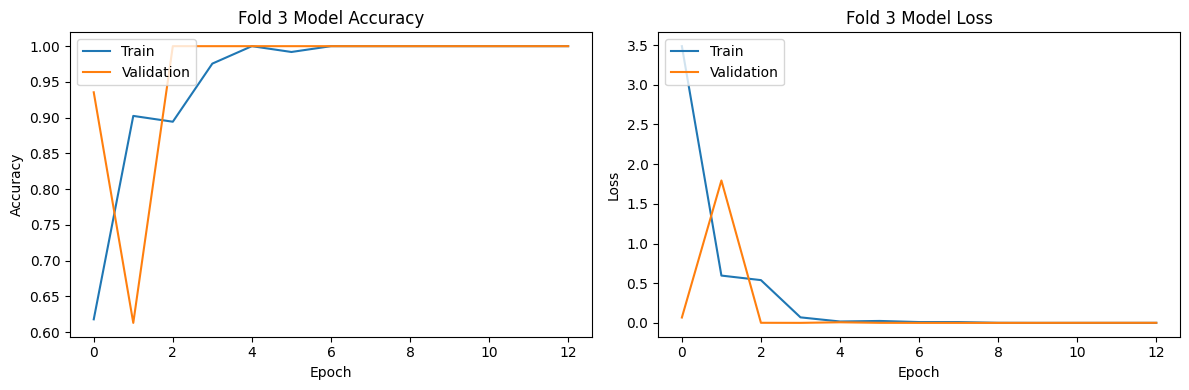

Fold 3 - Test Accuracy: 1.0000
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147s/step - accuracy: 0.6494 - loss: 4.8511  
Epoch 1: val_loss improved from inf to 0.00020, saving model to best_modelCekIni_fold_4.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 601s 151s/step - accuracy: 0.6464 - loss: 5.0286 - val_accuracy: 1.0000 - val_loss: 1.9932e-04
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148s/step - accuracy: 0.7105 - loss: 2.4011  
Epoch 2: val_loss did not improve from 0.00020
4/4 ━━━━━━━━━━━━━━━━━━━━ 611s 151s/step - accuracy: 0.7326 - loss: 2.2051 - val_accuracy: 0.7097 - val_loss: 3.4528
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 157s/step - accuracy: 0.9099 - loss: 0.9995  
Epoch 3: val_loss did not improve from 0.00020
4/4 ━━━━━━━━━━━━━━━━━━━━ 640s 160s/step - accuracy: 0.9101 - loss: 0.9534 - val_accuracy: 0.8387 - val_loss: 0.9362
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 202s/step - accuracy: 0.9597 - loss: 0.1571  
Epoch 4: val_loss did not improve from 0.00020
4/4 ━━━━━━━━━━━━━━━━━━━━ 782s 207s/step - 

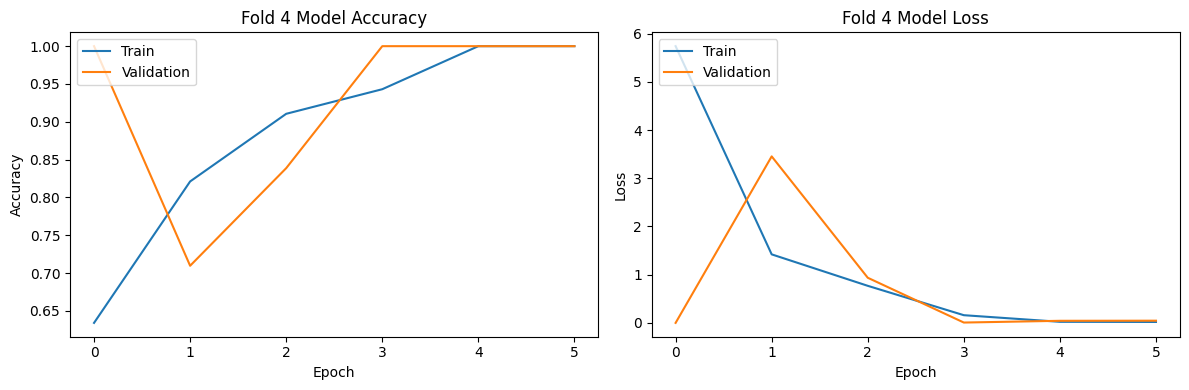

Fold 4 - Test Accuracy: 0.7895
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 188s/step - accuracy: 0.5890 - loss: 3.9523  
Epoch 1: val_loss improved from inf to 0.84194, saving model to best_modelCekIni_fold_5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 835s 192s/step - accuracy: 0.5996 - loss: 4.0801 - val_accuracy: 0.9355 - val_loss: 0.8419
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 213s/step - accuracy: 0.7672 - loss: 2.2436  
Epoch 2: val_loss did not improve from 0.84194
4/4 ━━━━━━━━━━━━━━━━━━━━ 834s 218s/step - accuracy: 0.7796 - loss: 2.1280 - val_accuracy: 0.5806 - val_loss: 2.7074
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 225s/step - accuracy: 0.8648 - loss: 0.7488  
Epoch 3: val_loss improved from 0.84194 to 0.62484, saving model to best_modelCekIni_fold_5.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 930s 229s/step - accuracy: 0.8691 - loss: 0.7259 - val_accuracy: 0.8065 - val_loss: 0.6248
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 262s/step - accuracy: 0.9521 - loss: 0.1334  
Epoch 4: val_loss improved from 0.62484 to

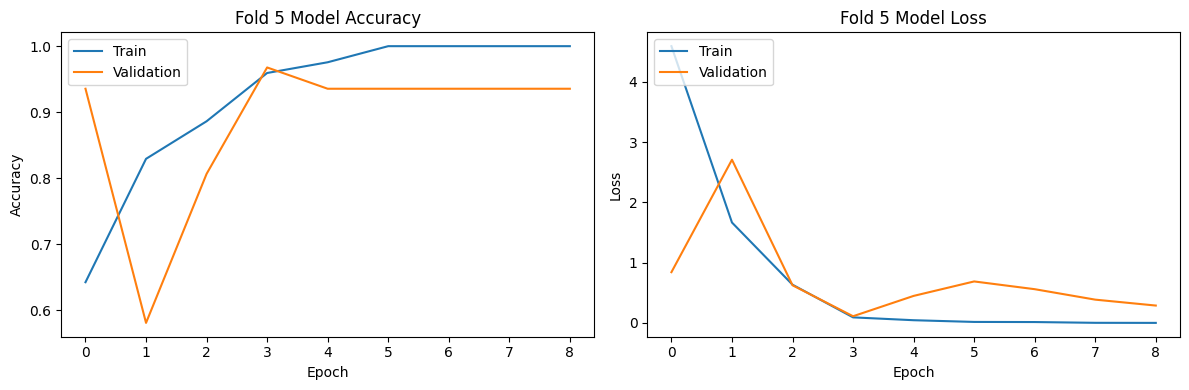

Fold 5 - Test Accuracy: 0.8947
Mean Test Accuracy: 0.9112


In [19]:
# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
fold = 1

for train_index, test_index in kf.split(X_resampled):
    # Ensure no overlap between train and test indices
    intersection = set(train_index) & set(test_index)
    assert len(intersection) == 0, f"Fold {fold} - Validation data is not separate from training data"

    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = create_model(input_shape)

    # Callbacks for early stopping and saving the best model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_modelCekIni_fold_{fold}.keras', monitor='val_loss', save_best_only=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Plot accuracy and loss graphs for each fold
    plot_history(history, fold)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold} - Test Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)
    fold += 1

print(f'Mean Test Accuracy: {np.mean(accuracies):.4f}')

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')
# Model Evaluation Section
# Assuming you have the true labels and predictions ready
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions if needed

# Insert the new code here
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='binary')  # Use 'micro', 'macro', 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# Print the scores
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Test Accuracy: 0.8947
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Precision: 0.9167
Recall: 0.9167
F1 Score: 0.9167
